In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import string

In [2]:
# ### Identify sample files in the results/ directory
# ## Organize directories
# dir_in = Path('/projects/wakedynamics/orybchuk/ldm-3d/results/cond_raaw/kl/attempt3')
# subdirs = []

# n_samples = 0
# for f in dir_in.glob('*'):
#     if f.is_dir():
#         n_samples += 1
#         subdirs.append(f)
# print("Number of samples:", n_samples)
# subdirs.sort()
        
# ## Prepare to load data
# file_number = "400080"
# gt_prefix = 'gt'
# gt_suffix = '_gt.npy'
# mask_prefix = 'gt'
# mask_suffix = '_mask.npy'
# pred_prefix = 'gt'
# pred_suffix = '_sample.npy'

# ## Load data
# gt = np.load(Path(subdirs[0], gt_prefix+file_number+gt_suffix))
# masked_gt = np.load(Path(subdirs[0], mask_prefix+file_number+mask_suffix))

# preds_shape = list(gt.shape)
# del preds_shape[0]
# preds_shape.insert(0,n_samples)
# preds = np.zeros(preds_shape)
# for i in range(n_samples):
#     preds[i,:,:,:,:] = np.load(Path(subdirs[i], pred_prefix+file_number+pred_suffix)).copy()

In [3]:
### Identify sample files in the logs/ directory
# dir_in = Path('/projects/wakedynamics/orybchuk/ldm-3d/logs/2022-12-01T22-01-37_inpaint_geo_raaw_kl1/images/test/')
# dir_in = Path('/projects/wakedynamics/orybchuk/ldm-3d/logs/2023-01-19T16-13-48_inpaint_geo_raaw_kl_ics-648000-pre/images/test/')
dir_in = Path('/projects/wakedynamics/orybchuk/ldm-3d/logs/2023-08-13T11-43-09_inpaint-geo-cond-kl1-split-channel/images/test/')
sample_files = []
fstart = 0  # Manually select this by inspecting .png's
fend = 49  # Manually select this by inspecting .png's

## Select full ground truth
gt = np.load(Path(dir_in, f'inputs_gs-000000_e-000000_b-{str(fstart).zfill(6)}.npy'))

## Select observation / masked data
masked_gt = np.load(Path(dir_in, f'conditioning_gs-000000_e-000000_b-{str(fstart).zfill(6)}.npy'))

## Identify sample files
sample_files_all = []
for f in dir_in.glob('samples_gs*.npy'):
    sample_files_all.append(f)
sample_files_all.sort()

# Manually subselect sample files based on one GT (CAREFUL HERE)
for i in range(fstart, fend+1):
    curr_iter = str(i).zfill(6)
    for curr_file in sample_files_all:
        if str(curr_file).endswith(curr_iter+'.npy'):
            sample_files.append(curr_file)

# Put samples into one array
n_batch = gt.shape[0]
n_samples = n_batch*(fend - fstart + 1)
preds_shape = list(gt.shape)
del preds_shape[0]
preds_shape.insert(0,n_samples)
preds = np.zeros(preds_shape)
ind = 0
for i in range(len(sample_files)):
    for batch in range(n_batch):
        preds[ind,:,:,:,:] = np.load(sample_files[i])[batch,:,:,:,:].copy()
        ind += 1
        
## Load Malik's conditional variance prediction (THIS IS SPECIFIC TO ONE OBS)
cdl_var = np.load('from_malik/plotPaper_raaw/stdev_0.npy')

In [4]:
def unnorm(xp, xmin, xmax):
    '''
    Take data from [-1,1] back to the original values
    '''
    return (xp + 1)*0.5*(xmax-xmin)+xmin

In [5]:
### Post process
## Replace mask values with NaN
masked_gt[masked_gt == 0.0] = np.nan

## Un-normalize data
umin, umax, vmin, vmax, wmin, wmax = 2.86975098, 12.5567627, -0.9810791, 4.91235352, -1.98095703, 2.5579834

for arr in [gt, masked_gt, preds]:
    arr[:,0,:,:,:] = unnorm(arr[:,0,:,:,:], umin, umax).copy()
    arr[:,1,:,:,:] = unnorm(arr[:,1,:,:,:], vmin, vmax).copy()
    arr[:,2,:,:,:] = unnorm(arr[:,2,:,:,:], wmin, wmax).copy()

In [6]:
### Create Dataset
## Prepare metadata
xdim = np.arange(0, 1920, 15)
ydim = np.arange(0, 1920, 15)
zdim = np.arange(0, 960, 15)
coords = dict(x=xdim, y=ydim, z=zdim)

## Create Dataset
ds = xr.Dataset(coords=coords)

ds['u_sample'] = (('sample', 'x', 'y', 'z'), preds[:,0,:,:,:])
ds['v_sample'] = (('sample', 'x', 'y', 'z'), preds[:,1,:,:,:])
ds['w_sample'] = (('sample', 'x', 'y', 'z'), preds[:,2,:,:,:])
ds['u_gt'] = (('x', 'y', 'z'), gt[0,0,:,:,:])
ds['v_gt'] = (('x', 'y', 'z'), gt[0,1,:,:,:])
ds['w_gt'] = (('x', 'y', 'z'), gt[0,2,:,:,:])
ds['u_mask'] = (('x', 'y', 'z'), masked_gt[0,0,:,:,:])
ds['v_mask'] = (('x', 'y', 'z'), masked_gt[0,1,:,:,:])
ds['w_mask'] = (('x', 'y', 'z'), masked_gt[0,2,:,:,:])

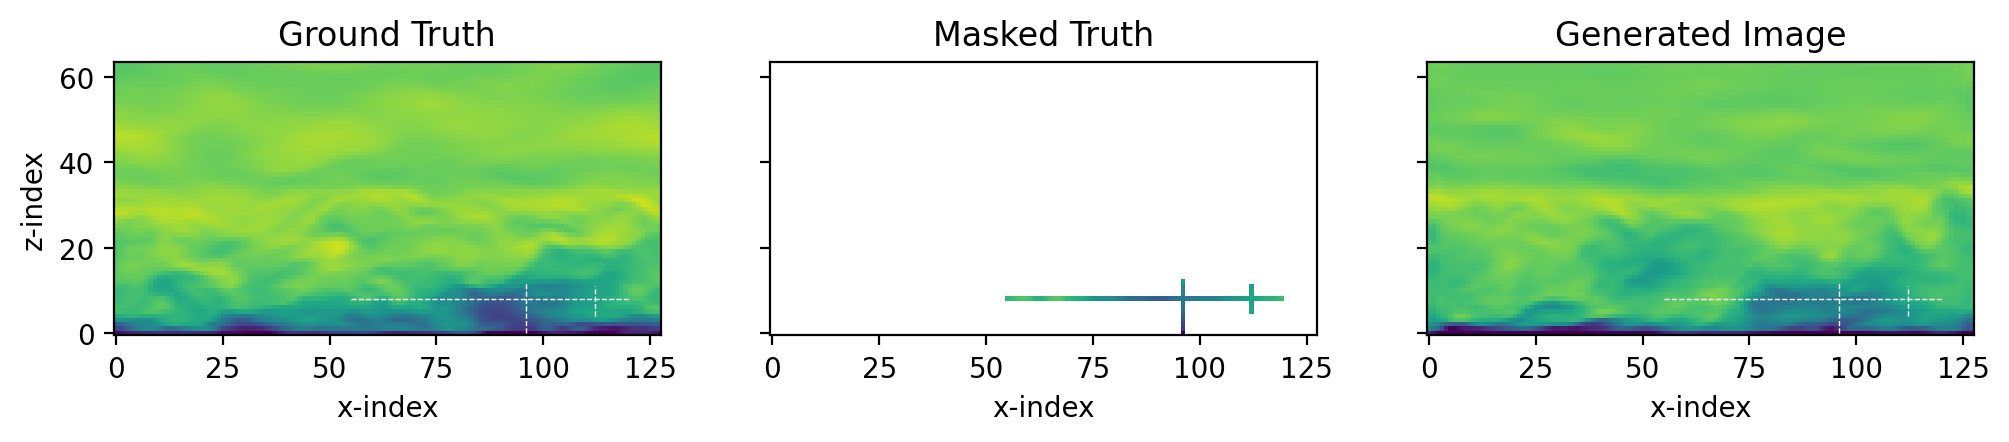

In [7]:
### Visualize ground truth, the mask, and one candidate image
fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=200, sharex=True, sharey=True)

for axs in ax[0:3:2]:
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
for axs in ax:
    axs.set_xlabel('x-index')

velnum = 0
varmin = 5
varmax = 11.5
sampnum = 0
planeind = 64

im1 = ax[0].imshow(ds['u_gt'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[1].imshow(ds['u_mask'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[2].imshow(ds['u_sample'].isel(y=planeind,sample=sampnum).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

ax[0].set_title("Ground Truth")
ax[1].set_title("Masked Truth")
ax[2].set_title("Generated Image")
ax[0].set_ylabel("z-index")
# ax[0].set_ylim(0, 20)
# ax[0].set_xlim(48, 128)

plt.show()

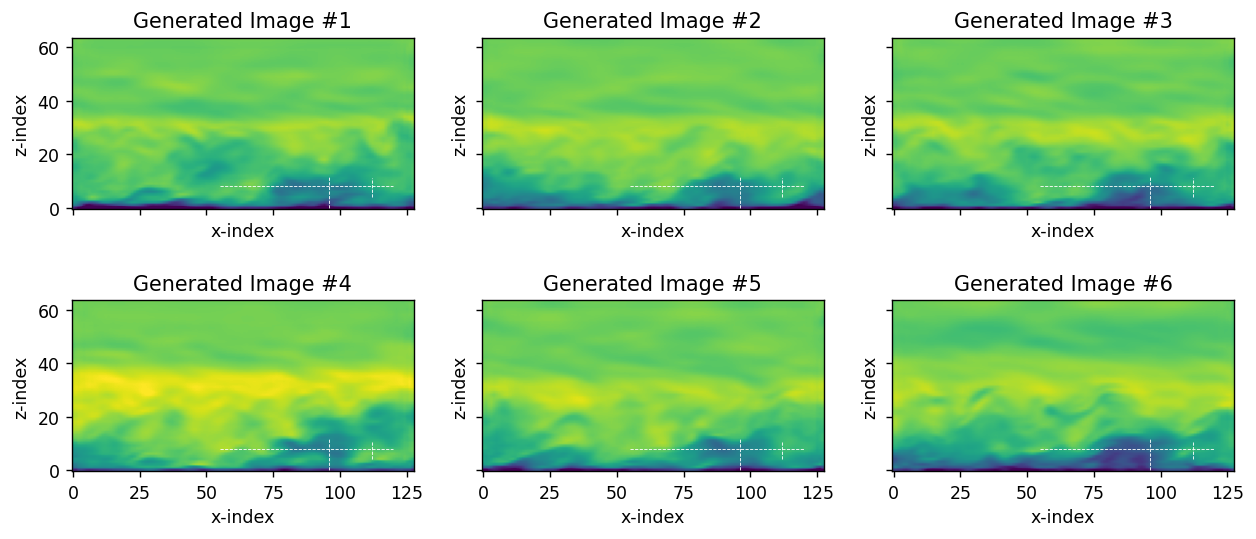

In [8]:
### Visualize many generated images
fig, ax = plt.subplots(2, 3, figsize=(12, 5), dpi=125, sharex=True, sharey=True)

for axs in ax.reshape(-1):
    axs.set_xlabel("x-index")
    axs.set_ylabel("z-index")

    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
k = 0
for i in range(2):
    for j in range(3):
        im1 = ax[i,j].imshow(ds['u_sample'].isel(y=planeind,sample=k).T,
                    vmin=varmin,
                    vmax=varmax,
                    origin='lower')
        ax[i,j].set_title(f"Generated Image #{k+1}")
        k += 1
        
# plt.savefig('../figs/qual_raaw_variability.png', bbox_inches='tight')

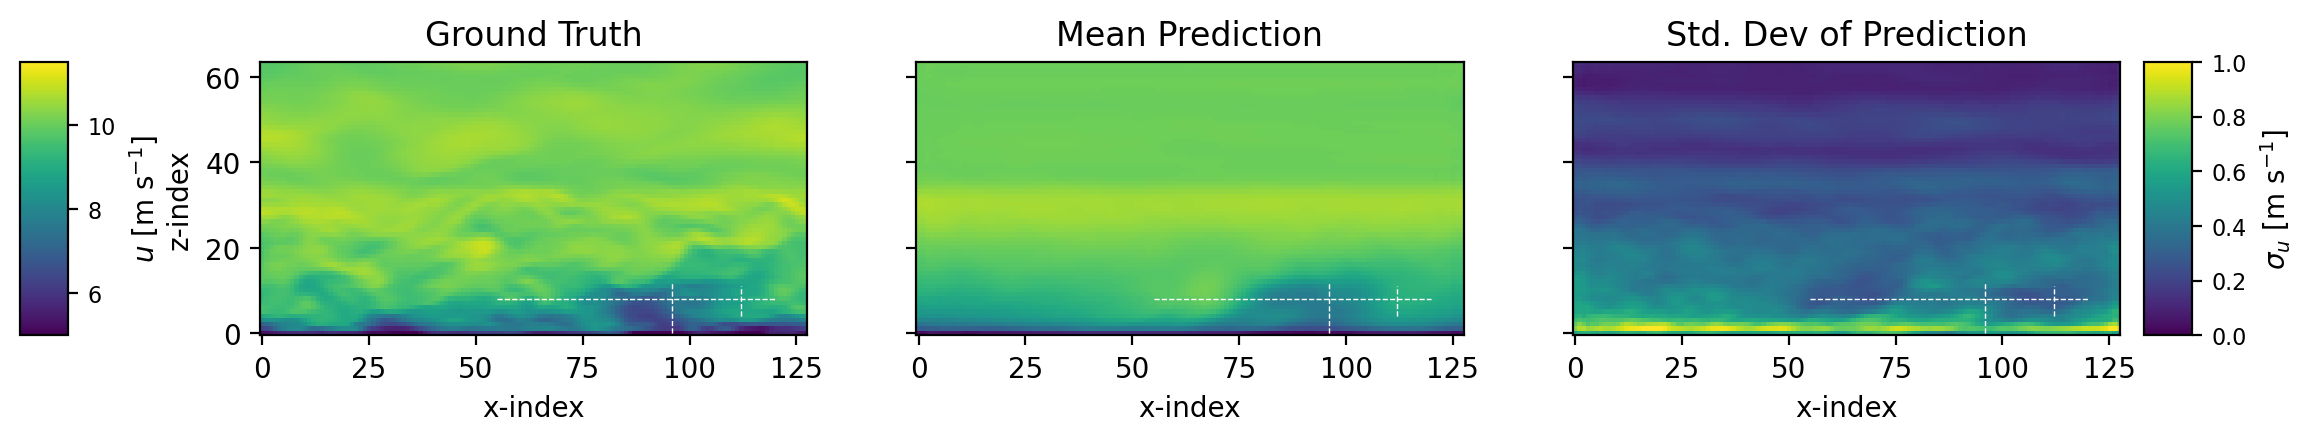

In [9]:
### Visualize ground truth, the mean, and the variance
fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=200, sharex=True, sharey=True)

for axs in ax.reshape(-1):
    axs.set_xlabel("x-index")
    
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
im1 = ax[0].imshow(ds['u_gt'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[1].imshow(ds['u_sample'].isel(y=planeind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[2].imshow(ds['u_sample'].isel(y=planeind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower')

ax[0].set_title("Ground Truth")
ax[1].set_title("Mean Prediction")
ax[2].set_title("Std. Dev of Prediction")
ax[0].set_ylabel("z-index")
# ax[0].set_ylim(0, 20)
# ax[0].set_xlim(48, 128)

## Colorbar
cax1 = fig.add_axes([ax[0].get_position().x0-0.10,
                     ax[2].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('$u$ [m s$^{-1}$]')
cbar1.ax.tick_params(labelsize=8) 

cax2 = fig.add_axes([ax[2].get_position().x1+0.01,
                     ax[2].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[0].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label('$\sigma_u$ [m s$^{-1}$]')
cbar2.ax.tick_params(labelsize=8) 

plt.show()

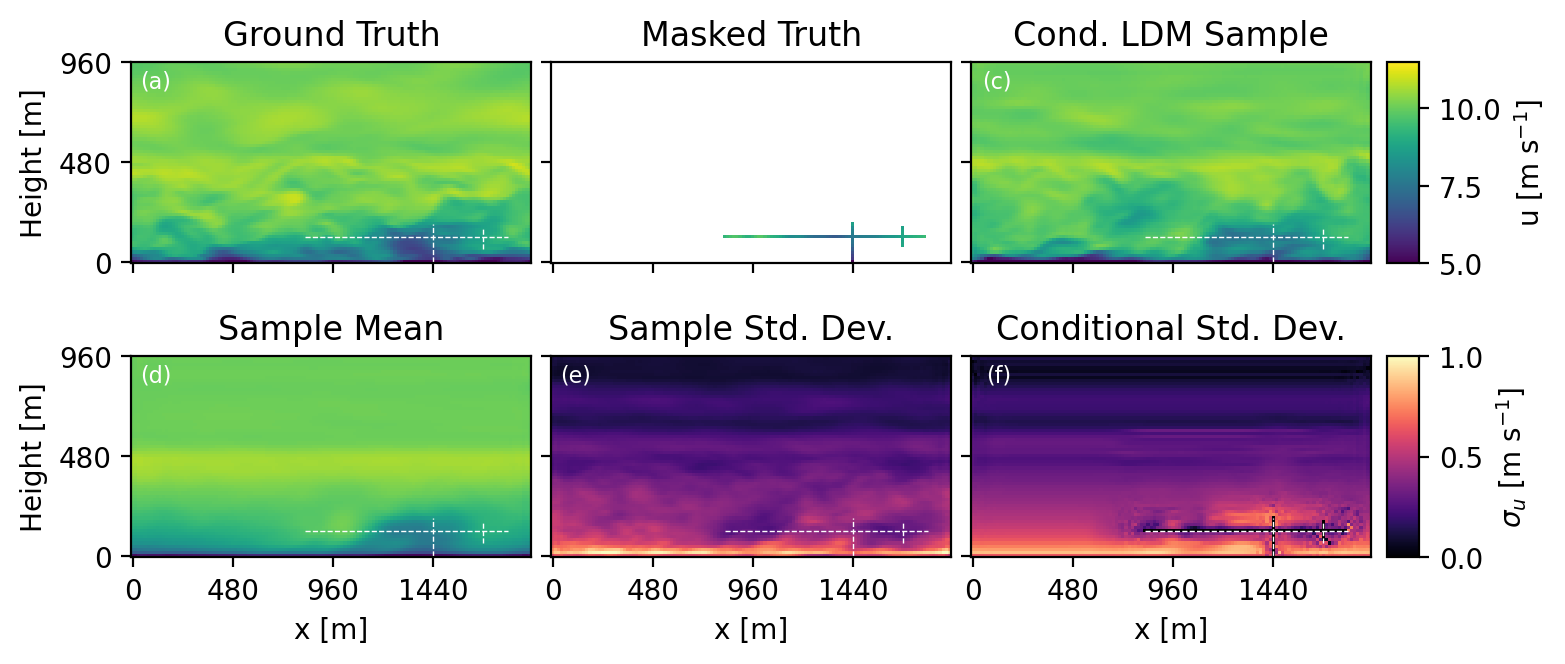

In [10]:
### Visualize ground truth, the mask, and one candidate image
fig, ax = plt.subplots(2, 3, figsize=(8, 3.5), dpi=200, sharex=True, sharey=True)

plt.subplots_adjust(wspace=0.05)

for axs in ax[1,:]:
    axs.set_xlabel('x [m]')
    
for axs in ax[:,0]:
    axs.set_ylabel('Height [m]')
    
i = 0
for axs in [ax[0,0], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]:
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
velnum = 0
# varmin = 5
# varmax = 11.5
sampnum = 0
planeind = 64

## Plot data
im1 = ax[0,0].imshow(ds['u_gt'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,1].imshow(ds['u_mask'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,2].imshow(ds['u_sample'].isel(y=planeind,sample=sampnum).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

im2 = ax[1,0].imshow(ds['u_sample'].isel(y=planeind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[1,1].imshow(ds['u_sample'].isel(y=planeind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')
im3 = ax[1,2].imshow(cdl_var[0,velnum,:,planeind,:].T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')

## Titles and axes
ax[0,0].set_title("Ground Truth")
ax[0,1].set_title("Masked Truth")
ax[0,2].set_title("Cond. LDM Sample")
ax[1,0].set_title("Sample Mean")
ax[1,1].set_title("Sample Std. Dev.")
ax[1,2].set_title("Conditional Std. Dev.")

## Axes
ax[0,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_xticks(np.array([0, 32, 64, 96]))
ax[1,0].set_xticklabels(15*np.array([0, 32, 64, 96]))
ax[0,0].set_yticklabels(15*np.array([0, 32, 64]))
ax[1,0].set_yticklabels(15*np.array([0, 32, 64]))

## Colorbars
cax1 = fig.add_axes([ax[0,2].get_position().x1+0.01,
                     ax[0,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('u [m s$^{-1}$]', fontsize=10)
cbar1.ax.tick_params(labelsize=10) 

cax2 = fig.add_axes([ax[0,2].get_position().x1+0.01,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label('$\sigma_u$ [m s$^{-1}$]', fontsize=10)
cbar2.ax.tick_params(labelsize=10) 

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.10,
          0.87,
          f'({letter})',
          fontsize=8,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
    
# plt.savefig('../figs/qual_cond_raaw_planes_u.pdf', bbox_inches='tight')

plt.show()

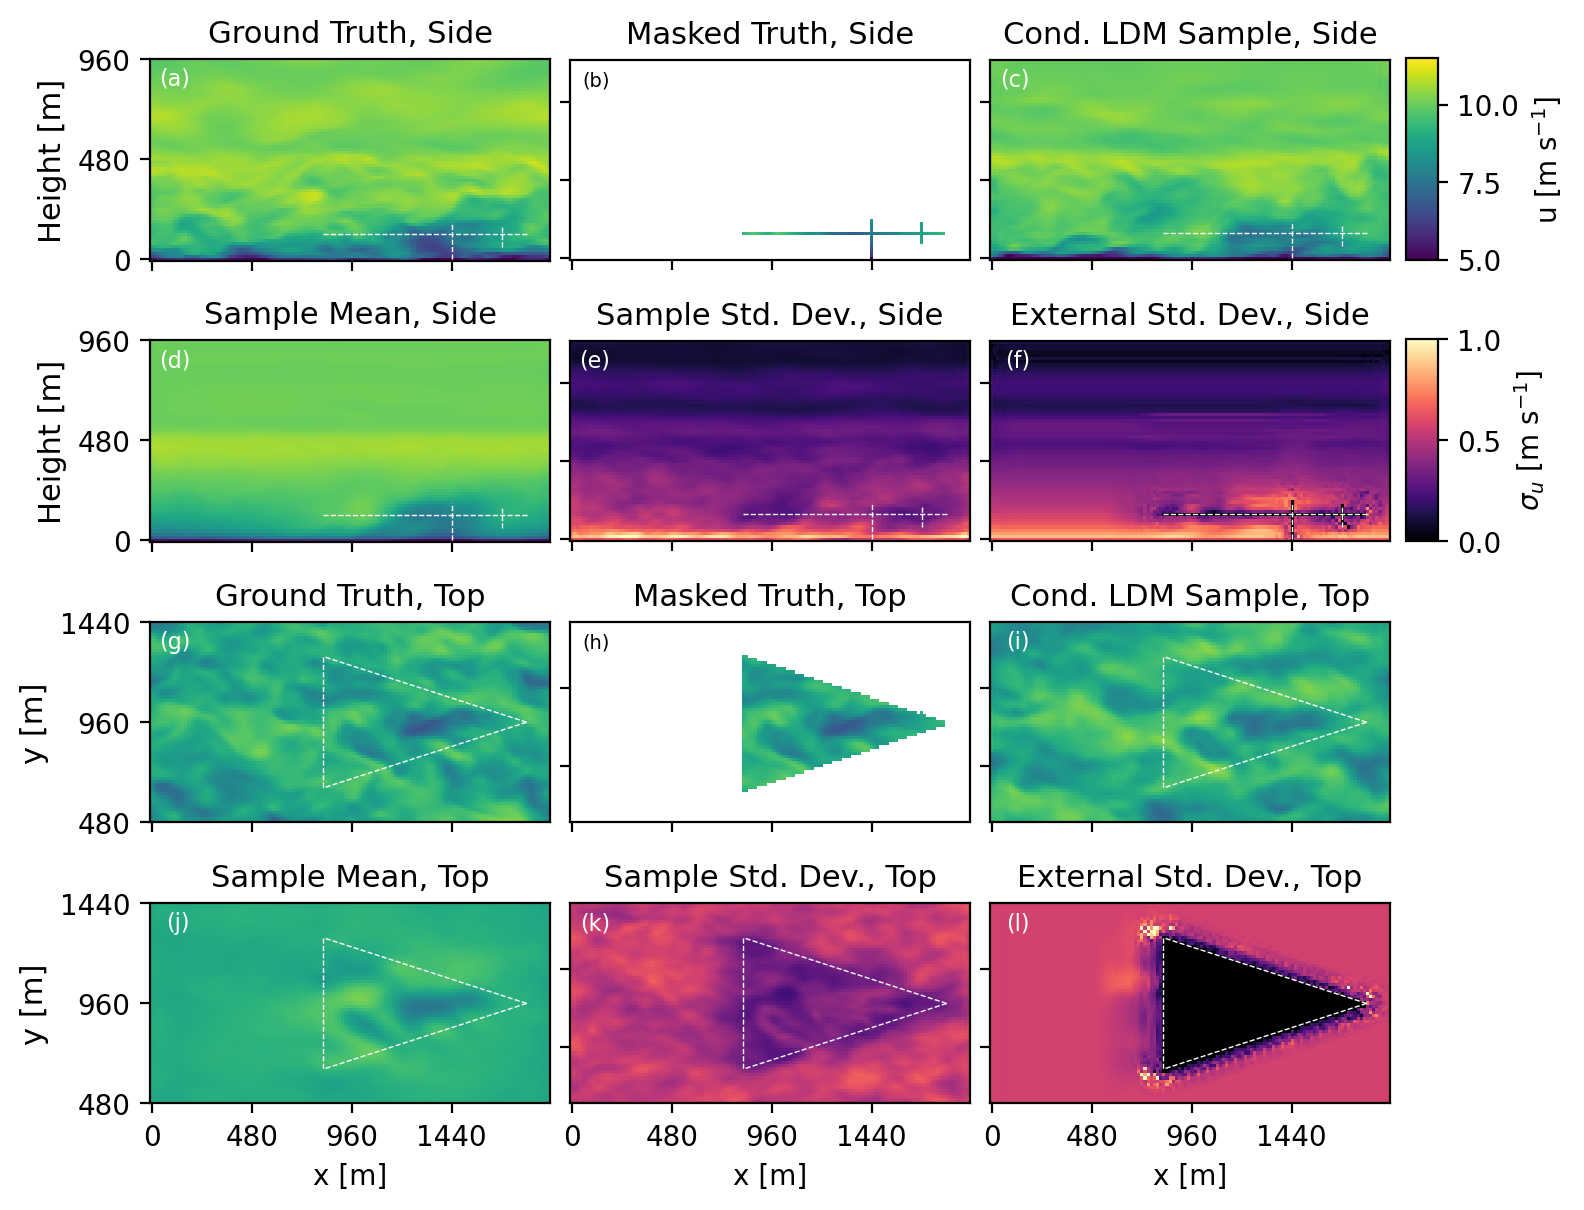

In [11]:
### Visualize ground truth, the mask, and one candidate image
fig, ax = plt.subplots(4, 3, figsize=(8, 7), dpi=200, sharex=True)

plt.subplots_adjust(wspace=0.05)

for axs in ax[-1,:]:
    axs.set_xlabel('x [m]')
    axs.set_ylim(32,96)
for axs in ax[2,:]:
    axs.set_ylim(32,96)
    
i = 0
for axs in [ax[0,0], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]:
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
for axs in [ax[2,0], ax[2,2], ax[3,0], ax[3,1], ax[3,2]]:
    jlidar_offset = round((120-55)*np.tan(np.deg2rad(18)))
    axs.plot([120, 55], [64, 64+jlidar_offset], color='white', ls='--', lw=0.5)
    axs.plot([120, 55], [64, 64-jlidar_offset], color='white', ls='--', lw=0.5)
    axs.plot([55, 55], [64+jlidar_offset, 64-jlidar_offset], color='white', ls='--', lw=0.5)

velnum = 0
# varmin = 5
# varmax = 11.5
yind = 64
zind = 8
    
## Plot data
im1 = ax[0,0].imshow(ds['u_gt'].isel(y=yind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,1].imshow(ds['u_mask'].isel(y=yind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,2].imshow(ds['u_sample'].isel(y=yind,sample=sampnum).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

im2 = ax[1,0].imshow(ds['u_sample'].isel(y=yind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[1,1].imshow(ds['u_sample'].isel(y=yind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')
im3 = ax[1,2].imshow(cdl_var[0,velnum,:,yind,:].T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')

im1 = ax[2,0].imshow(ds['u_gt'].isel(z=zind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[2,1].imshow(ds['u_mask'].isel(z=zind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[2,2].imshow(ds['u_sample'].isel(z=zind,sample=sampnum).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

im2 = ax[3,0].imshow(ds['u_sample'].isel(z=zind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[3,1].imshow(ds['u_sample'].isel(z=zind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')
im3 = ax[3,2].imshow(cdl_var[0,velnum,:,:,zind].T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')

## Titles and axes
ax[0,0].set_title("Ground Truth, Side", fontsize=11)
ax[0,1].set_title("Masked Truth, Side", fontsize=11)
ax[0,2].set_title("Cond. LDM Sample, Side", fontsize=11)
ax[1,0].set_title("Sample Mean, Side", fontsize=11)
ax[1,1].set_title("Sample Std. Dev., Side", fontsize=11)
ax[1,2].set_title("External Std. Dev., Side", fontsize=11)
ax[2,0].set_title("Ground Truth, Top", fontsize=11)
ax[2,1].set_title("Masked Truth, Top", fontsize=11)
ax[2,2].set_title("Cond. LDM Sample, Top", fontsize=11)
ax[3,0].set_title("Sample Mean, Top", fontsize=11)
ax[3,1].set_title("Sample Std. Dev., Top", fontsize=11)
ax[3,2].set_title("External Std. Dev., Top", fontsize=11)
ax[0,0].set_ylabel('Height [m]', fontsize=11)
ax[1,0].set_ylabel('Height [m]', fontsize=11)
ax[2,0].set_ylabel('y [m]', fontsize=11)
ax[3,0].set_ylabel('y [m]', fontsize=11)

## Axes
ax[0,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_xticks(np.array([0, 32, 64, 96]))
ax[1,0].set_xticklabels(15*np.array([0, 32, 64, 96]))
ax[0,0].set_yticklabels(15*np.array([0, 32, 64]))
ax[1,0].set_yticklabels(15*np.array([0, 32, 64]))

ax[2,0].set_yticks(np.array([32, 64, 96]))
ax[2,0].set_yticklabels(15*np.array([32, 64, 96]))
ax[3,0].set_yticks(np.array([32, 64, 96]))
ax[3,0].set_yticklabels(15*np.array([32, 64, 96]))

for axs in ax[:,1:].flatten():
    axs.set_yticklabels([])

## Colorbars
cax1 = fig.add_axes([ax[0,2].get_position().x1+0.01,
                     ax[0,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('u [m s$^{-1}$]', fontsize=10)
cbar1.ax.tick_params(labelsize=10) 

cax2 = fig.add_axes([ax[0,2].get_position().x1+0.01,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label('$\sigma_u$ [m s$^{-1}$]', fontsize=10)
cbar2.ax.tick_params(labelsize=10) 

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.10,
          0.87,
          f'({letter})',
          fontsize=8,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
ax[0,1].text(0.10,
      0.87,
      f'(b)',
      fontsize=7,
      transform = ax[0,1].transAxes,
      horizontalalignment='right',
        color='black')
ax[2,1].text(0.10,
      0.87,
      f'(h)',
      fontsize=7,
      transform = ax[2,1].transAxes,
      horizontalalignment='right',
        color='black')
    
    
# plt.savefig('../figs/qual_cond_raaw_planes_u_top_and_side.pdf', bbox_inches='tight')

plt.show()

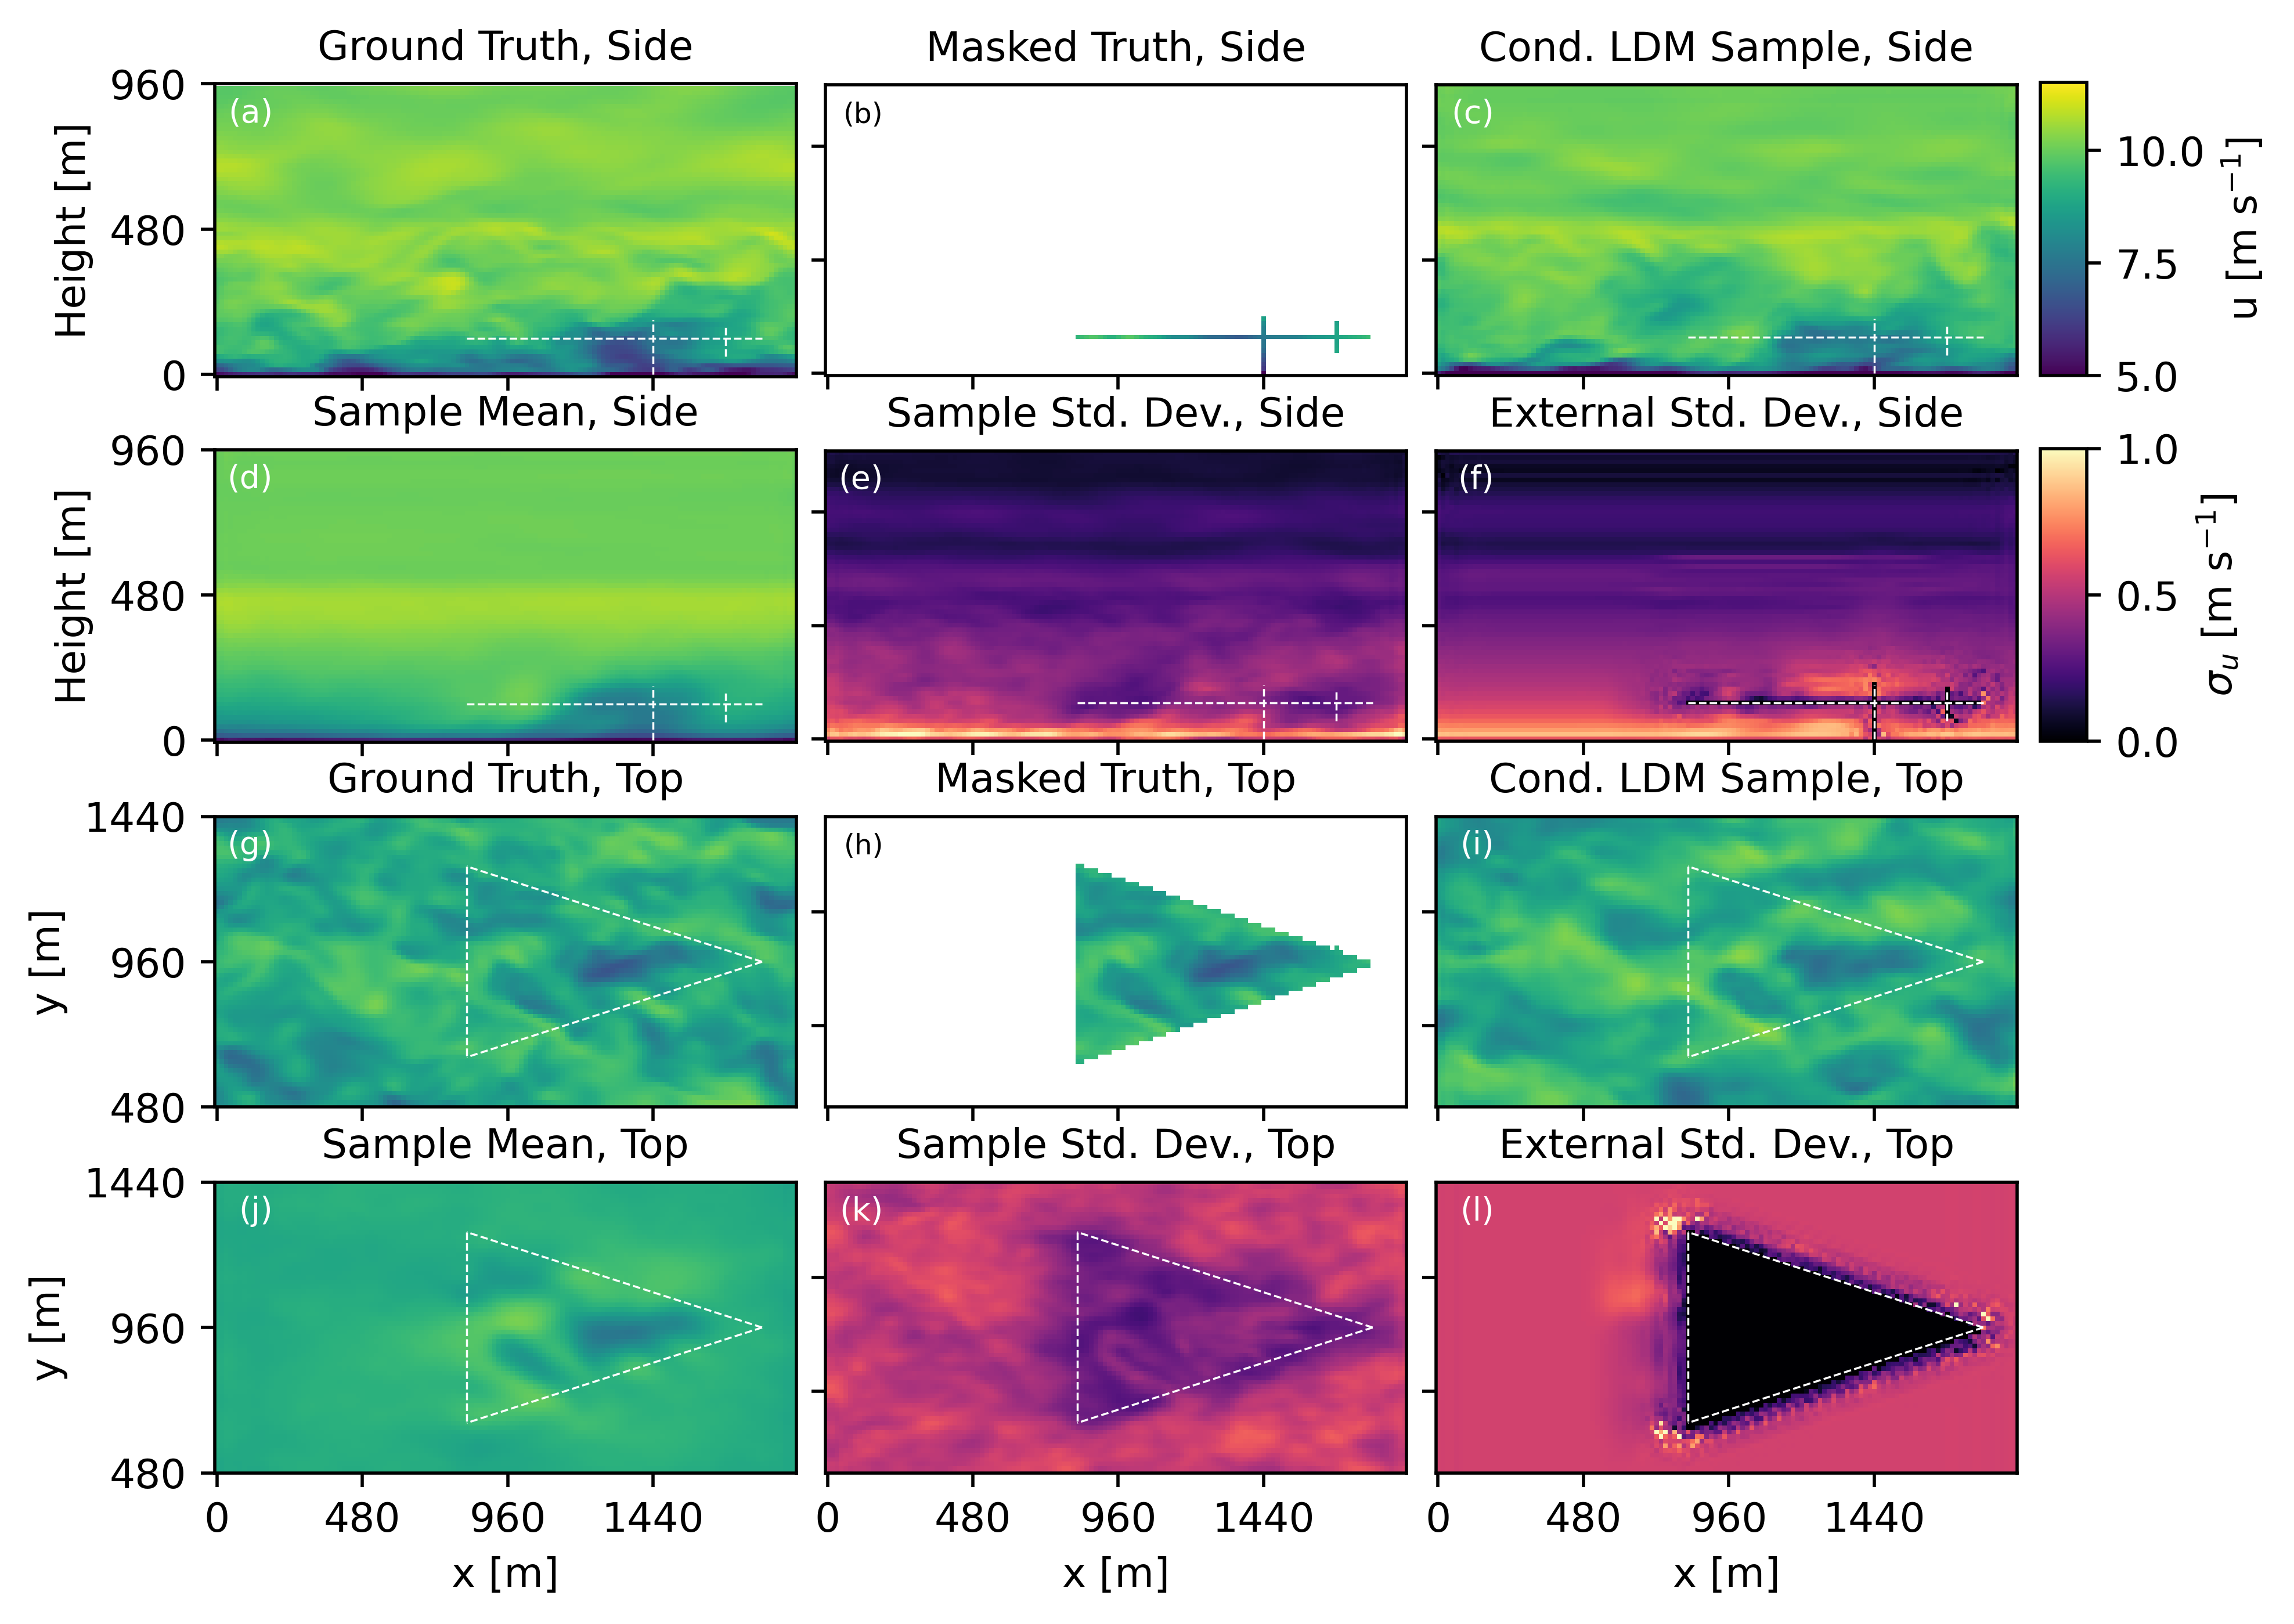

In [15]:
# ### Visualize ground truth, the mask, and one candidate image
# fig, ax = plt.subplots(4, 3, figsize=(8.0139, 6.2739), dpi=500, sharex=True)

# plt.subplots_adjust(wspace=0.05)

# for axs in ax[-1,:]:
#     axs.set_xlabel('x [m]')
#     axs.set_ylim(32,96)
# for axs in ax[2,:]:
#     axs.set_ylim(32,96)
    
# i = 0
# for axs in [ax[0,0], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]:
#     axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
#     axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
#     axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
# for axs in [ax[2,0], ax[2,2], ax[3,0], ax[3,1], ax[3,2]]:
#     jlidar_offset = round((120-55)*np.tan(np.deg2rad(18)))
#     axs.plot([120, 55], [64, 64+jlidar_offset], color='white', ls='--', lw=0.5)
#     axs.plot([120, 55], [64, 64-jlidar_offset], color='white', ls='--', lw=0.5)
#     axs.plot([55, 55], [64+jlidar_offset, 64-jlidar_offset], color='white', ls='--', lw=0.5)

# velnum = 0
# # varmin = 5
# # varmax = 11.5
# yind = 64
# zind = 8
    
# ## Plot data
# im1 = ax[0,0].imshow(ds['u_gt'].isel(y=yind).T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')
# im1 = ax[0,1].imshow(ds['u_mask'].isel(y=yind).T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')
# im1 = ax[0,2].imshow(ds['u_sample'].isel(y=yind,sample=sampnum).T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')

# im2 = ax[1,0].imshow(ds['u_sample'].isel(y=yind).mean('sample').T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')
# im3 = ax[1,1].imshow(ds['u_sample'].isel(y=yind).std('sample').T,
#             vmin=0.0,
#             vmax=1.0,
#             origin='lower',
#             cmap='magma')
# im3 = ax[1,2].imshow(cdl_var[0,velnum,:,yind,:].T,
#             vmin=0.0,
#             vmax=1.0,
#             origin='lower',
#             cmap='magma')

# im1 = ax[2,0].imshow(ds['u_gt'].isel(z=zind).T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')
# im1 = ax[2,1].imshow(ds['u_mask'].isel(z=zind).T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')
# im1 = ax[2,2].imshow(ds['u_sample'].isel(z=zind,sample=sampnum).T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')

# im2 = ax[3,0].imshow(ds['u_sample'].isel(z=zind).mean('sample').T,
#             vmin=varmin,
#             vmax=varmax,
#             origin='lower')
# im3 = ax[3,1].imshow(ds['u_sample'].isel(z=zind).std('sample').T,
#             vmin=0.0,
#             vmax=1.0,
#             origin='lower',
#             cmap='magma')
# im3 = ax[3,2].imshow(cdl_var[0,velnum,:,:,zind].T,
#             vmin=0.0,
#             vmax=1.0,
#             origin='lower',
#             cmap='magma')

# ## Titles and axes
# ax[0,0].set_title("Ground Truth, Side", fontsize=10)
# ax[0,1].set_title("Masked Truth, Side", fontsize=10)
# ax[0,2].set_title("Cond. LDM Sample, Side", fontsize=10)
# ax[1,0].set_title("Sample Mean, Side", fontsize=10)
# ax[1,1].set_title("Sample Std. Dev., Side", fontsize=10)
# ax[1,2].set_title("External Std. Dev., Side", fontsize=10)
# ax[2,0].set_title("Ground Truth, Top", fontsize=10)
# ax[2,1].set_title("Masked Truth, Top", fontsize=10)
# ax[2,2].set_title("Cond. LDM Sample, Top", fontsize=10)
# ax[3,0].set_title("Sample Mean, Top", fontsize=10)
# ax[3,1].set_title("Sample Std. Dev., Top", fontsize=10)
# ax[3,2].set_title("External Std. Dev., Top", fontsize=10)
# ax[0,0].set_ylabel('Height [m]', fontsize=10)
# ax[1,0].set_ylabel('Height [m]', fontsize=10)
# ax[2,0].set_ylabel('y [m]', fontsize=10)
# ax[3,0].set_ylabel('y [m]', fontsize=10)

# ## Axes
# ax[0,0].set_yticks(np.array([0, 32, 64]))
# ax[1,0].set_yticks(np.array([0, 32, 64]))
# ax[1,0].set_xticks(np.array([0, 32, 64, 96]))
# ax[1,0].set_xticklabels(15*np.array([0, 32, 64, 96]))
# ax[0,0].set_yticklabels(15*np.array([0, 32, 64]))
# ax[1,0].set_yticklabels(15*np.array([0, 32, 64]))

# ax[2,0].set_yticks(np.array([32, 64, 96]))
# ax[2,0].set_yticklabels(15*np.array([32, 64, 96]))
# ax[3,0].set_yticks(np.array([32, 64, 96]))
# ax[3,0].set_yticklabels(15*np.array([32, 64, 96]))

# for axs in ax[:,1:].flatten():
#     axs.set_yticklabels([])

# ## Colorbars
# cax1 = fig.add_axes([ax[0,2].get_position().x1+0.01,
#                      ax[0,-1].get_position().y0,
#                      0.02,
#                      ax[0,0].get_position().y1-ax[0,0].get_position().y0])
# cbar1 = fig.colorbar(im1, cax=cax1)
# cbar1.set_label('u [m s$^{-1}$]', fontsize=10)
# cbar1.ax.tick_params(labelsize=10) 

# cax2 = fig.add_axes([ax[0,2].get_position().x1+0.01,
#                      ax[1,-1].get_position().y0,
#                      0.02,
#                      ax[0,0].get_position().y1-ax[0,0].get_position().y0])
# cbar2 = fig.colorbar(im3, cax=cax2)
# cbar2.set_label('$\sigma_u$ [m s$^{-1}$]', fontsize=10)
# cbar2.ax.tick_params(labelsize=10) 

# ## Subpanel labels
# for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
#     axs.text(0.10,
#           0.87,
#           f'({letter})',
#           fontsize=8,
#           transform = axs.transAxes,
#           horizontalalignment='right',
#             color='white')
# ax[0,1].text(0.10,
#       0.87,
#       f'(b)',
#       fontsize=7,
#       transform = ax[0,1].transAxes,
#       horizontalalignment='right',
#         color='black')
# ax[2,1].text(0.10,
#       0.87,
#       f'(h)',
#       fontsize=7,
#       transform = ax[2,1].transAxes,
#       horizontalalignment='right',
#         color='black')
    
    
# # plt.savefig('../figs/cover_image.jpeg', bbox_inches='tight', dpi=500)

# plt.show()

# 2nd observation

In [12]:
### Identify sample files in the logs/ directory
# dir_in = Path('/projects/wakedynamics/orybchuk/ldm-3d/logs/2022-12-01T22-01-37_inpaint_geo_raaw_kl1/images/test/')
sample_files = []
fstart = 50  # Manually select this by inspecting .png's
fend = 99  # Manually select this by inspecting .png's

## Select full ground truth
gt = np.load(Path(dir_in, f'inputs_gs-000000_e-000000_b-{str(fstart).zfill(6)}.npy'))

## Select observation / masked data
masked_gt = np.load(Path(dir_in, f'conditioning_gs-000000_e-000000_b-{str(fstart).zfill(6)}.npy'))

## Identify sample files
sample_files_all = []
for f in dir_in.glob('samples_gs*.npy'):
    sample_files_all.append(f)
sample_files_all.sort()

# Manually subselect sample files based on one GT (CAREFUL HERE)
for i in range(fstart, fend+1):
    curr_iter = str(i).zfill(6)
    for curr_file in sample_files_all:
        if str(curr_file).endswith(curr_iter+'.npy'):
            sample_files.append(curr_file)

# Put samples into one array
n_batch = gt.shape[0]
n_samples = n_batch*(fend - fstart + 1)
preds_shape = list(gt.shape)
del preds_shape[0]
preds_shape.insert(0,n_samples)
preds = np.zeros(preds_shape)
ind = 0
for i in range(len(sample_files)):
    for batch in range(n_batch):
        preds[ind,:,:,:,:] = np.load(sample_files[i])[batch,:,:,:,:].copy()
        ind += 1

In [13]:
### Post process
## Replace mask values with NaN
masked_gt[masked_gt == 0.0] = np.nan

## Un-normalize data
umin, umax, vmin, vmax, wmin, wmax = 2.86975098, 12.5567627, -0.9810791, 4.91235352, -1.98095703, 2.5579834

for arr in [gt, masked_gt, preds]:
    arr[:,0,:,:,:] = unnorm(arr[:,0,:,:,:], umin, umax).copy()
    arr[:,1,:,:,:] = unnorm(arr[:,1,:,:,:], vmin, vmax).copy()
    arr[:,2,:,:,:] = unnorm(arr[:,2,:,:,:], wmin, wmax).copy()

In [14]:
## Create Dataset
ds2 = xr.Dataset(coords=coords)

ds2['u_sample'] = (('sample', 'x', 'y', 'z'), preds[:,0,:,:,:])
ds2['v_sample'] = (('sample', 'x', 'y', 'z'), preds[:,1,:,:,:])
ds2['w_sample'] = (('sample', 'x', 'y', 'z'), preds[:,2,:,:,:])
ds2['u_gt'] = (('x', 'y', 'z'), gt[0,0,:,:,:])
ds2['v_gt'] = (('x', 'y', 'z'), gt[0,1,:,:,:])
ds2['w_gt'] = (('x', 'y', 'z'), gt[0,2,:,:,:])
ds2['u_mask'] = (('x', 'y', 'z'), masked_gt[0,0,:,:,:])
ds2['v_mask'] = (('x', 'y', 'z'), masked_gt[0,1,:,:,:])
ds2['w_mask'] = (('x', 'y', 'z'), masked_gt[0,2,:,:,:])

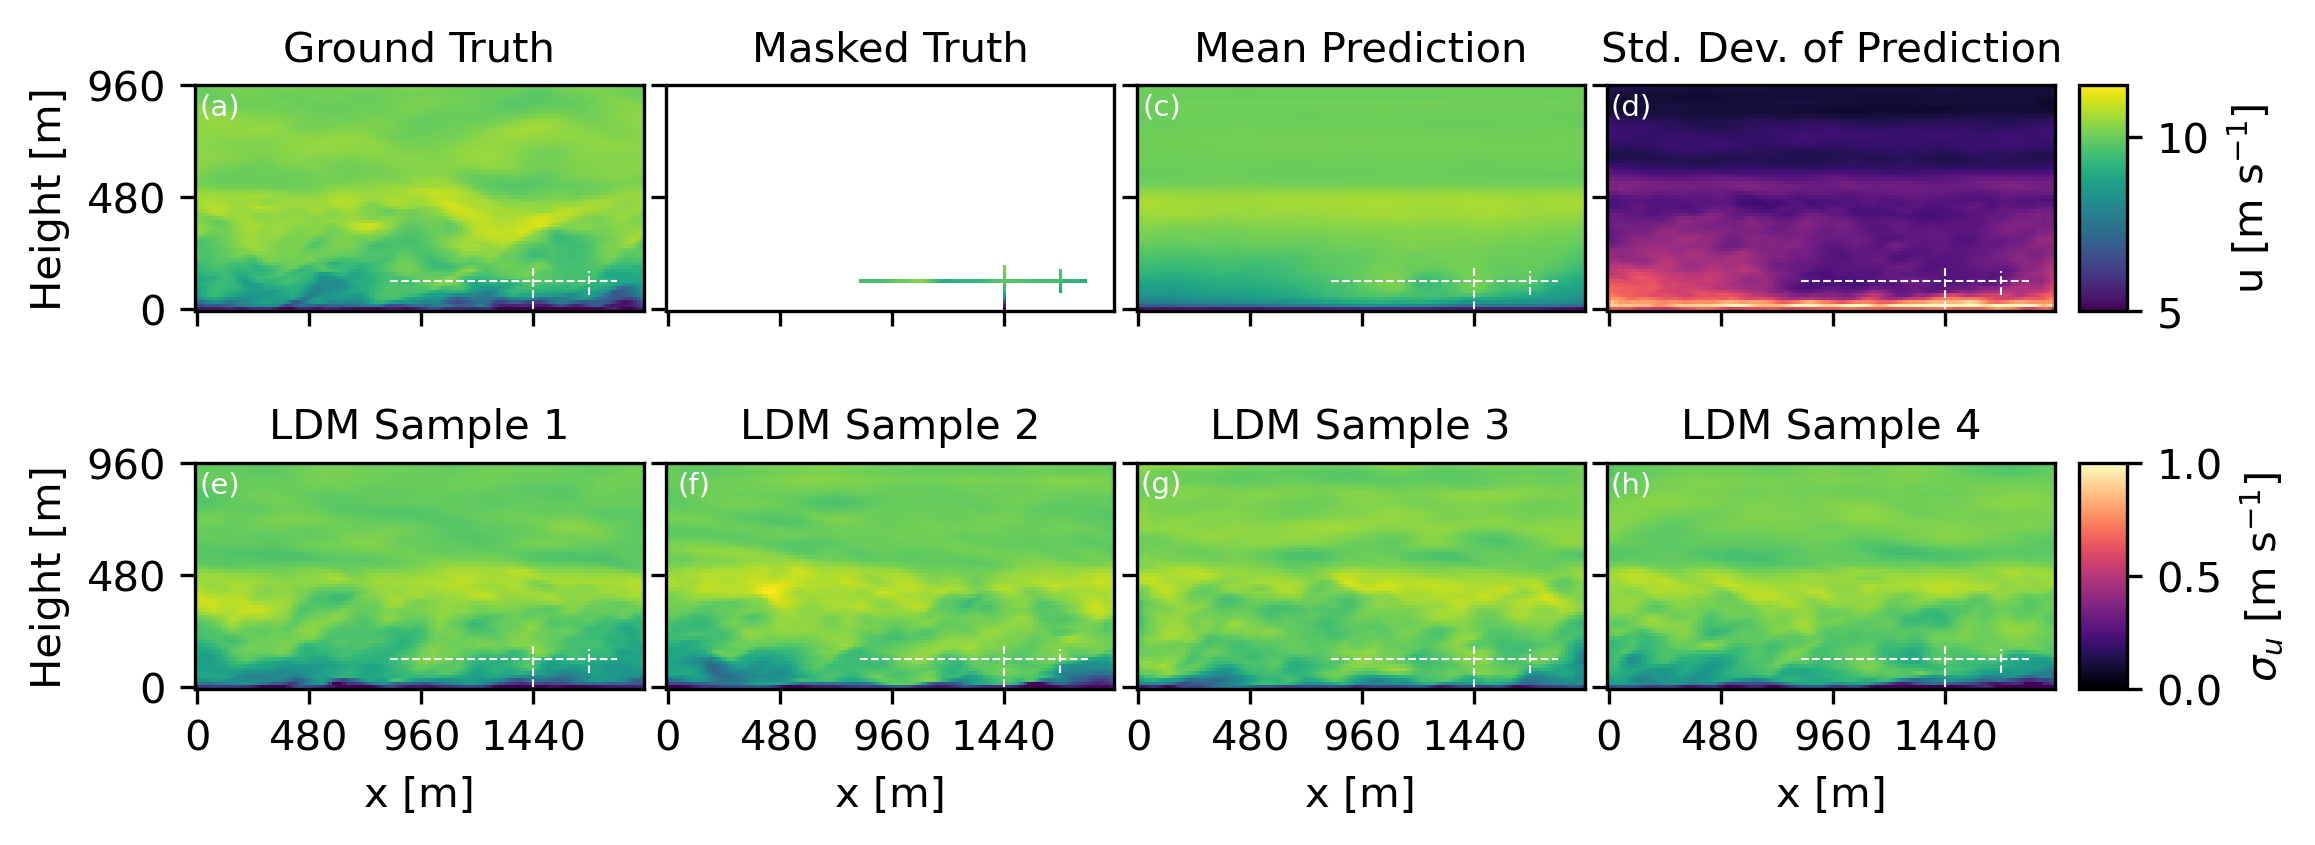

In [15]:
### Visualize ground truth, the mask, and one candidate image
fig, ax = plt.subplots(2, 4, figsize=(8, 3.0), dpi=300, sharex=True, sharey=True)

plt.subplots_adjust(wspace=0.05)

for axs in ax[1,:]:
    axs.set_xlabel('x [m]')
    
for axs in [ax[0,0], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3]]:
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)

# velnum = 0
# varmin = 5
# varmax = 11.5
planeind = 64

## Plot data
im1 = ax[0,0].imshow(ds2['u_gt'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,1].imshow(ds2['u_mask'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[0,2].imshow(ds2['u_sample'].isel(y=planeind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[0,3].imshow(ds2['u_sample'].isel(y=planeind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')


im1 = ax[1,0].imshow(ds2['u_sample'].isel(y=planeind,sample=0).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,1].imshow(ds2['u_sample'].isel(y=planeind,sample=1).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,2].imshow(ds2['u_sample'].isel(y=planeind,sample=2).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,3].imshow(ds2['u_sample'].isel(y=planeind,sample=3).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')


## Titles and axes
ax[0,0].set_title("Ground Truth", fontsize=10)
ax[0,1].set_title("Masked Truth", fontsize=10)
ax[0,2].set_title("Mean Prediction", fontsize=10)
ax[0,3].set_title("Std. Dev. of Prediction", fontsize=10)

ax[1,0].set_title("LDM Sample 1", fontsize=10)
ax[1,1].set_title("LDM Sample 2", fontsize=10)
ax[1,2].set_title("LDM Sample 3", fontsize=10)
ax[1,3].set_title("LDM Sample 4", fontsize=10)

ax[0,0].set_ylabel("Height [m]")
ax[1,0].set_ylabel("Height [m]")

## Axes
ax[0,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_xticks(np.array([0, 32, 64, 96]))
ax[1,0].set_xticklabels(15*np.array([0, 32, 64, 96]))
ax[0,0].set_yticklabels(15*np.array([0, 32, 64]))
ax[1,0].set_yticklabels(15*np.array([0, 32, 64]))

## Colorbars
cax1 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[0,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('u [m s$^{-1}$]', fontsize=10)
cbar1.ax.tick_params(labelsize=10) 

cax2 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label('$\sigma_u$ [m s$^{-1}$]', fontsize=10)
cbar2.ax.tick_params(labelsize=10) 

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.10,
          0.87,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
    
# plt.savefig('../figs/qual_cond_raaw_planes2_u.pdf', bbox_inches='tight')

plt.show()

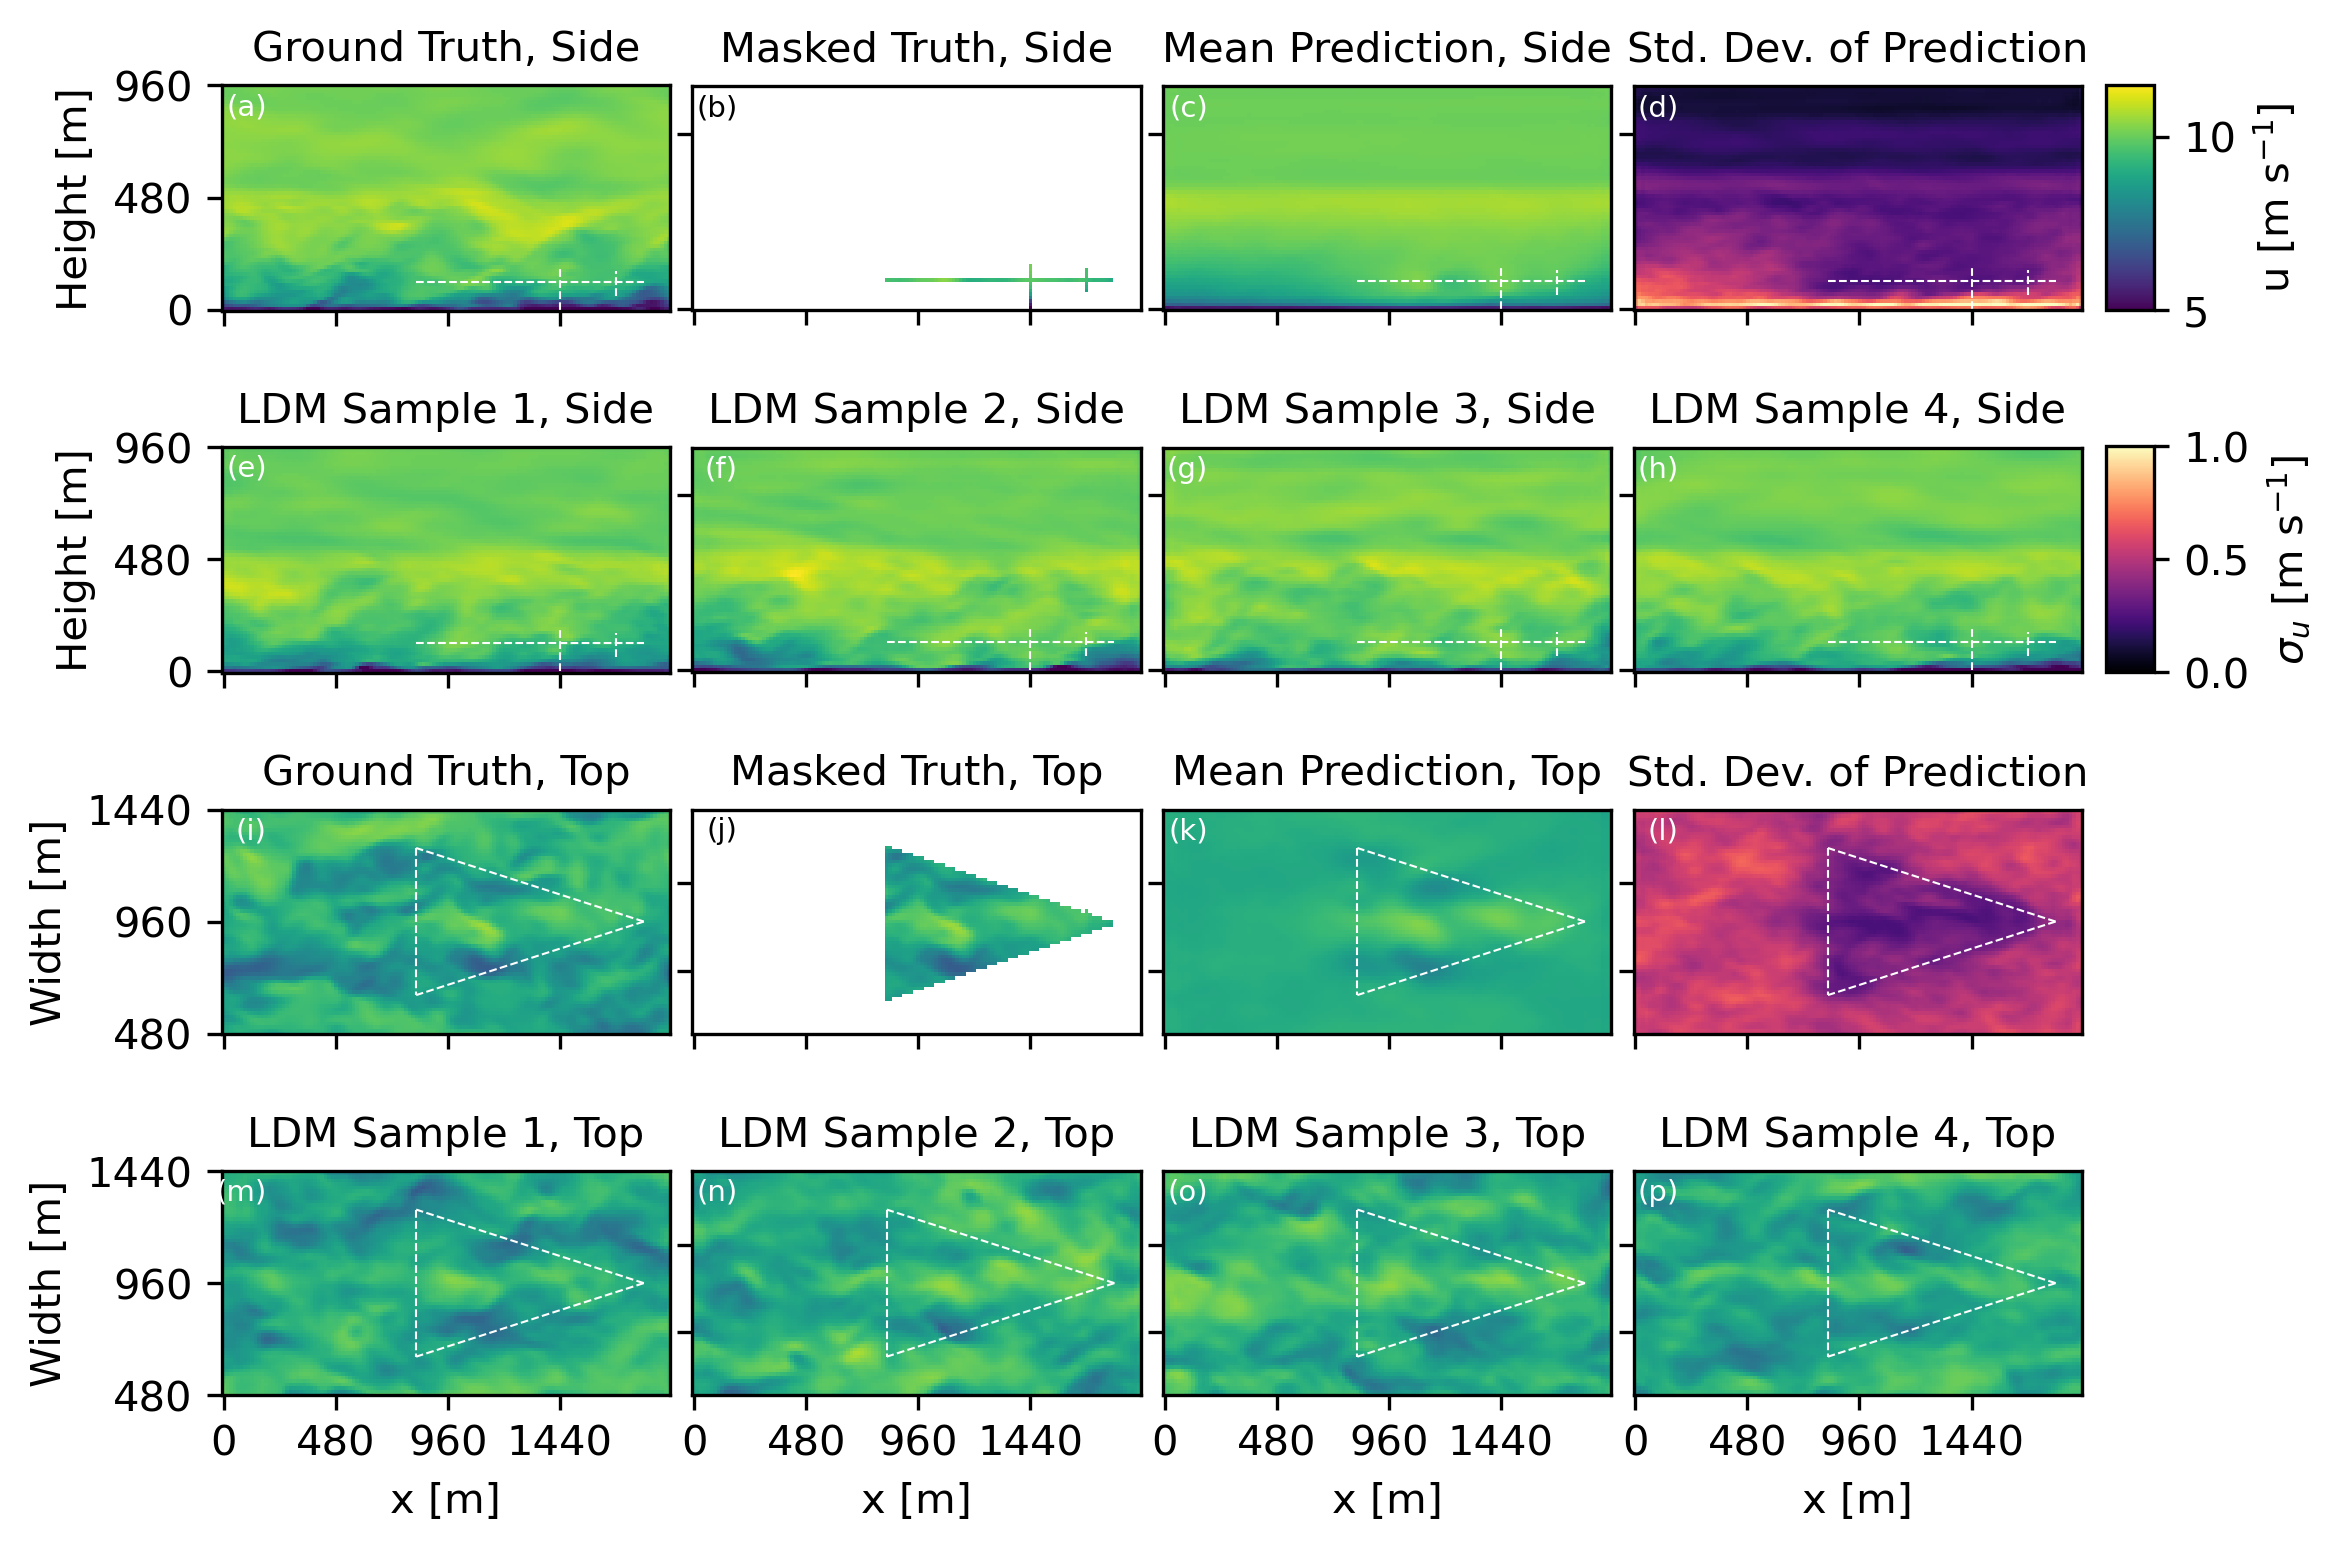

In [16]:
### Side view + Top-down view
fig, ax = plt.subplots(4, 4, figsize=(8, 6.0), dpi=300, sharex=True)

plt.subplots_adjust(wspace=0.05)

for axs in ax[2,:]:
    axs.set_ylim(32,96)

for axs in ax[-1,:]:
    axs.set_xlabel('x [m]')
    axs.set_ylim(32,96)
    
for axs in [ax[0,0], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3]]:
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
for axs in [ax[2,0], ax[2,2], ax[2,3], ax[3,0], ax[3,1], ax[3,2], ax[3,3]]:
    jlidar_offset = round((120-55)*np.tan(np.deg2rad(18)))
    axs.plot([120, 55], [64, 64+jlidar_offset], color='white', ls='--', lw=0.5)
    axs.plot([120, 55], [64, 64-jlidar_offset], color='white', ls='--', lw=0.5)
    axs.plot([55, 55], [64+jlidar_offset, 64-jlidar_offset], color='white', ls='--', lw=0.5)

# velnum = 0
# varmin = 5
# varmax = 11.5
yind = 64
zind = 8

## Plot data
im1 = ax[0,0].imshow(ds2['u_gt'].isel(y=yind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,1].imshow(ds2['u_mask'].isel(y=yind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[0,2].imshow(ds2['u_sample'].isel(y=yind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[0,3].imshow(ds2['u_sample'].isel(y=yind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')

im1 = ax[2,0].imshow(ds2['u_gt'].isel(z=zind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[2,1].imshow(ds2['u_mask'].isel(z=zind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[2,2].imshow(ds2['u_sample'].isel(z=zind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[2,3].imshow(ds2['u_sample'].isel(z=zind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')


im1 = ax[1,0].imshow(ds2['u_sample'].isel(y=yind,sample=0).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,1].imshow(ds2['u_sample'].isel(y=yind,sample=1).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,2].imshow(ds2['u_sample'].isel(y=yind,sample=2).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,3].imshow(ds2['u_sample'].isel(y=yind,sample=3).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

im1 = ax[3,0].imshow(ds2['u_sample'].isel(z=zind,sample=0).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[3,1].imshow(ds2['u_sample'].isel(z=zind,sample=1).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[3,2].imshow(ds2['u_sample'].isel(z=zind,sample=2).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[3,3].imshow(ds2['u_sample'].isel(z=zind,sample=3).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

## Titles and axes
ax[0,0].set_title("Ground Truth, Side", fontsize=10)
ax[0,1].set_title("Masked Truth, Side", fontsize=10)
ax[0,2].set_title("Mean Prediction, Side", fontsize=10)
ax[0,3].set_title("Std. Dev. of Prediction", fontsize=10)

ax[2,0].set_title("Ground Truth, Top", fontsize=10)
ax[2,1].set_title("Masked Truth, Top", fontsize=10)
ax[2,2].set_title("Mean Prediction, Top", fontsize=10)
ax[2,3].set_title("Std. Dev. of Prediction", fontsize=10)

ax[1,0].set_title("LDM Sample 1, Side", fontsize=10)
ax[1,1].set_title("LDM Sample 2, Side", fontsize=10)
ax[1,2].set_title("LDM Sample 3, Side", fontsize=10)
ax[1,3].set_title("LDM Sample 4, Side", fontsize=10)

ax[3,0].set_title("LDM Sample 1, Top", fontsize=10)
ax[3,1].set_title("LDM Sample 2, Top", fontsize=10)
ax[3,2].set_title("LDM Sample 3, Top", fontsize=10)
ax[3,3].set_title("LDM Sample 4, Top", fontsize=10)

ax[0,0].set_ylabel("Height [m]")
ax[2,0].set_ylabel("Width [m]")
ax[1,0].set_ylabel("Height [m]")
ax[3,0].set_ylabel("Width [m]")

## Axes
ax[0,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_xticks(np.array([0, 32, 64, 96]))
ax[1,0].set_xticklabels(15*np.array([0, 32, 64, 96]))
ax[0,0].set_yticklabels(15*np.array([0, 32, 64]))
ax[1,0].set_yticklabels(15*np.array([0, 32, 64]))

ax[2,0].set_yticks(np.array([32, 64, 96]))
ax[2,0].set_yticklabels(15*np.array([32, 64, 96]))
ax[3,0].set_yticks(np.array([32, 64, 96]))
ax[3,0].set_yticklabels(15*np.array([32, 64, 96]))

for axs in ax[:,1:].flatten():
    axs.set_yticklabels([])

## Colorbars
cax1 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[0,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('u [m s$^{-1}$]', fontsize=10)
cbar1.ax.tick_params(labelsize=10) 

cax2 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label('$\sigma_u$ [m s$^{-1}$]', fontsize=10)
cbar2.ax.tick_params(labelsize=10) 

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.10,
          0.87,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
ax[0,1].text(0.10,
      0.87,
      f'(b)',
      fontsize=7,
      transform = ax[0,1].transAxes,
      horizontalalignment='right',
        color='black')
ax[2,1].text(0.10,
      0.87,
      f'(j)',
      fontsize=7,
      transform = ax[2,1].transAxes,
      horizontalalignment='right',
        color='black')

# plt.savefig('../figs/qual_cond_raaw_planes2_u_top_and_side.pdf', bbox_inches='tight')
    
plt.show()

# 3rd observation

In [17]:
### Identify sample files in the logs/ directory
# dir_in = Path('/projects/wakedynamics/orybchuk/ldm-3d/logs/2022-12-01T22-01-37_inpaint_geo_raaw_kl1/images/test/')
sample_files = []
fstart = 100  # Manually select this by inspecting .png's
fend = 149  # Manually select this by inspecting .png's

## Select full ground truth
gt = np.load(Path(dir_in, f'inputs_gs-000000_e-000000_b-{str(fstart).zfill(6)}.npy'))

## Select observation / masked data
masked_gt = np.load(Path(dir_in, f'conditioning_gs-000000_e-000000_b-{str(fstart).zfill(6)}.npy'))

## Identify sample files
sample_files_all = []
for f in dir_in.glob('samples_gs*.npy'):
    sample_files_all.append(f)
sample_files_all.sort()

# Manually subselect sample files based on one GT (CAREFUL HERE)
for i in range(fstart, fend+1):
    curr_iter = str(i).zfill(6)
    for curr_file in sample_files_all:
        if str(curr_file).endswith(curr_iter+'.npy'):
            sample_files.append(curr_file)

# Put samples into one array
n_batch = gt.shape[0]
n_samples = n_batch*(fend - fstart + 1)
preds_shape = list(gt.shape)
del preds_shape[0]
preds_shape.insert(0,n_samples)
preds = np.zeros(preds_shape)
ind = 0
for i in range(len(sample_files)):
    for batch in range(n_batch):
        preds[ind,:,:,:,:] = np.load(sample_files[i])[batch,:,:,:,:].copy()
        ind += 1

In [18]:
### Post process
## Replace mask values with NaN
masked_gt[masked_gt == 0.0] = np.nan

## Un-normalize data
umin, umax, vmin, vmax, wmin, wmax = 2.86975098, 12.5567627, -0.9810791, 4.91235352, -1.98095703, 2.5579834

for arr in [gt, masked_gt, preds]:
    arr[:,0,:,:,:] = unnorm(arr[:,0,:,:,:], umin, umax).copy()
    arr[:,1,:,:,:] = unnorm(arr[:,1,:,:,:], vmin, vmax).copy()
    arr[:,2,:,:,:] = unnorm(arr[:,2,:,:,:], wmin, wmax).copy()

In [19]:
## Create Dataset
ds3 = xr.Dataset(coords=coords)

ds3['u_sample'] = (('sample', 'x', 'y', 'z'), preds[:,0,:,:,:])
ds3['v_sample'] = (('sample', 'x', 'y', 'z'), preds[:,1,:,:,:])
ds3['w_sample'] = (('sample', 'x', 'y', 'z'), preds[:,2,:,:,:])
ds3['u_gt'] = (('x', 'y', 'z'), gt[0,0,:,:,:])
ds3['v_gt'] = (('x', 'y', 'z'), gt[0,1,:,:,:])
ds3['w_gt'] = (('x', 'y', 'z'), gt[0,2,:,:,:])
ds3['u_mask'] = (('x', 'y', 'z'), masked_gt[0,0,:,:,:])
ds3['v_mask'] = (('x', 'y', 'z'), masked_gt[0,1,:,:,:])
ds3['w_mask'] = (('x', 'y', 'z'), masked_gt[0,2,:,:,:])

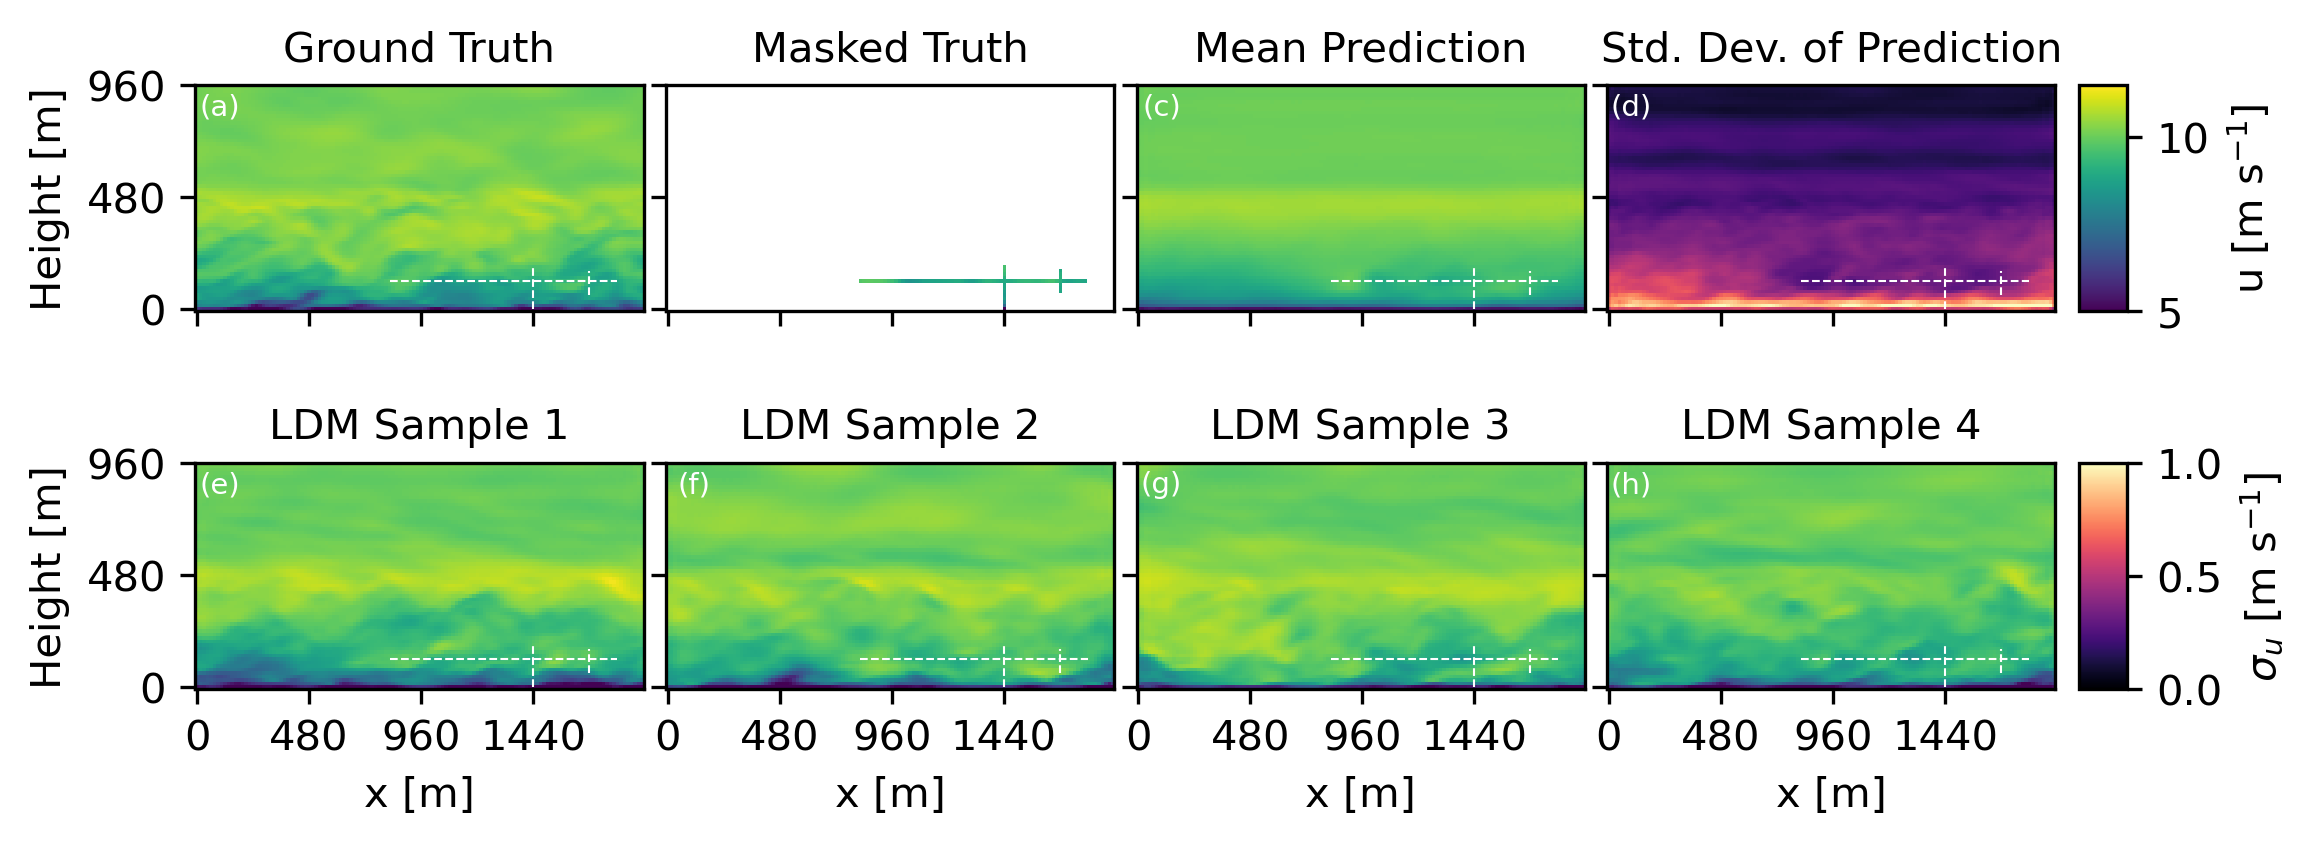

In [20]:
### Visualize ground truth, the mask, and one candidate image
fig, ax = plt.subplots(2, 4, figsize=(8, 3.0), dpi=300, sharex=True, sharey=True)

plt.subplots_adjust(wspace=0.05)

for axs in ax[1,:]:
    axs.set_xlabel('x [m]')
    
for axs in [ax[0,0], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3]]:
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)

# velnum = 0
# varmin = 5
# varmax = 11.5
planeind = 64

## Plot data
im1 = ax[0,0].imshow(ds3['u_gt'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,1].imshow(ds3['u_mask'].isel(y=planeind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[0,2].imshow(ds3['u_sample'].isel(y=planeind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[0,3].imshow(ds3['u_sample'].isel(y=planeind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')


im1 = ax[1,0].imshow(ds3['u_sample'].isel(y=planeind,sample=0).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,1].imshow(ds3['u_sample'].isel(y=planeind,sample=1).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,2].imshow(ds3['u_sample'].isel(y=planeind,sample=2).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,3].imshow(ds3['u_sample'].isel(y=planeind,sample=3).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')


## Titles and axes
ax[0,0].set_title("Ground Truth", fontsize=10)
ax[0,1].set_title("Masked Truth", fontsize=10)
ax[0,2].set_title("Mean Prediction", fontsize=10)
ax[0,3].set_title("Std. Dev. of Prediction", fontsize=10)

ax[1,0].set_title("LDM Sample 1", fontsize=10)
ax[1,1].set_title("LDM Sample 2", fontsize=10)
ax[1,2].set_title("LDM Sample 3", fontsize=10)
ax[1,3].set_title("LDM Sample 4", fontsize=10)

ax[0,0].set_ylabel("Height [m]")
ax[1,0].set_ylabel("Height [m]")

## Axes
ax[0,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_xticks(np.array([0, 32, 64, 96]))
ax[1,0].set_xticklabels(15*np.array([0, 32, 64, 96]))
ax[0,0].set_yticklabels(15*np.array([0, 32, 64]))
ax[1,0].set_yticklabels(15*np.array([0, 32, 64]))

## Colorbars
cax1 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[0,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('u [m s$^{-1}$]', fontsize=10)
cbar1.ax.tick_params(labelsize=10) 

cax2 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label('$\sigma_u$ [m s$^{-1}$]', fontsize=10)
cbar2.ax.tick_params(labelsize=10) 

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.10,
          0.87,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
    
# plt.savefig('../figs/qual_cond_raaw_planes3_u.pdf', bbox_inches='tight')

plt.show()

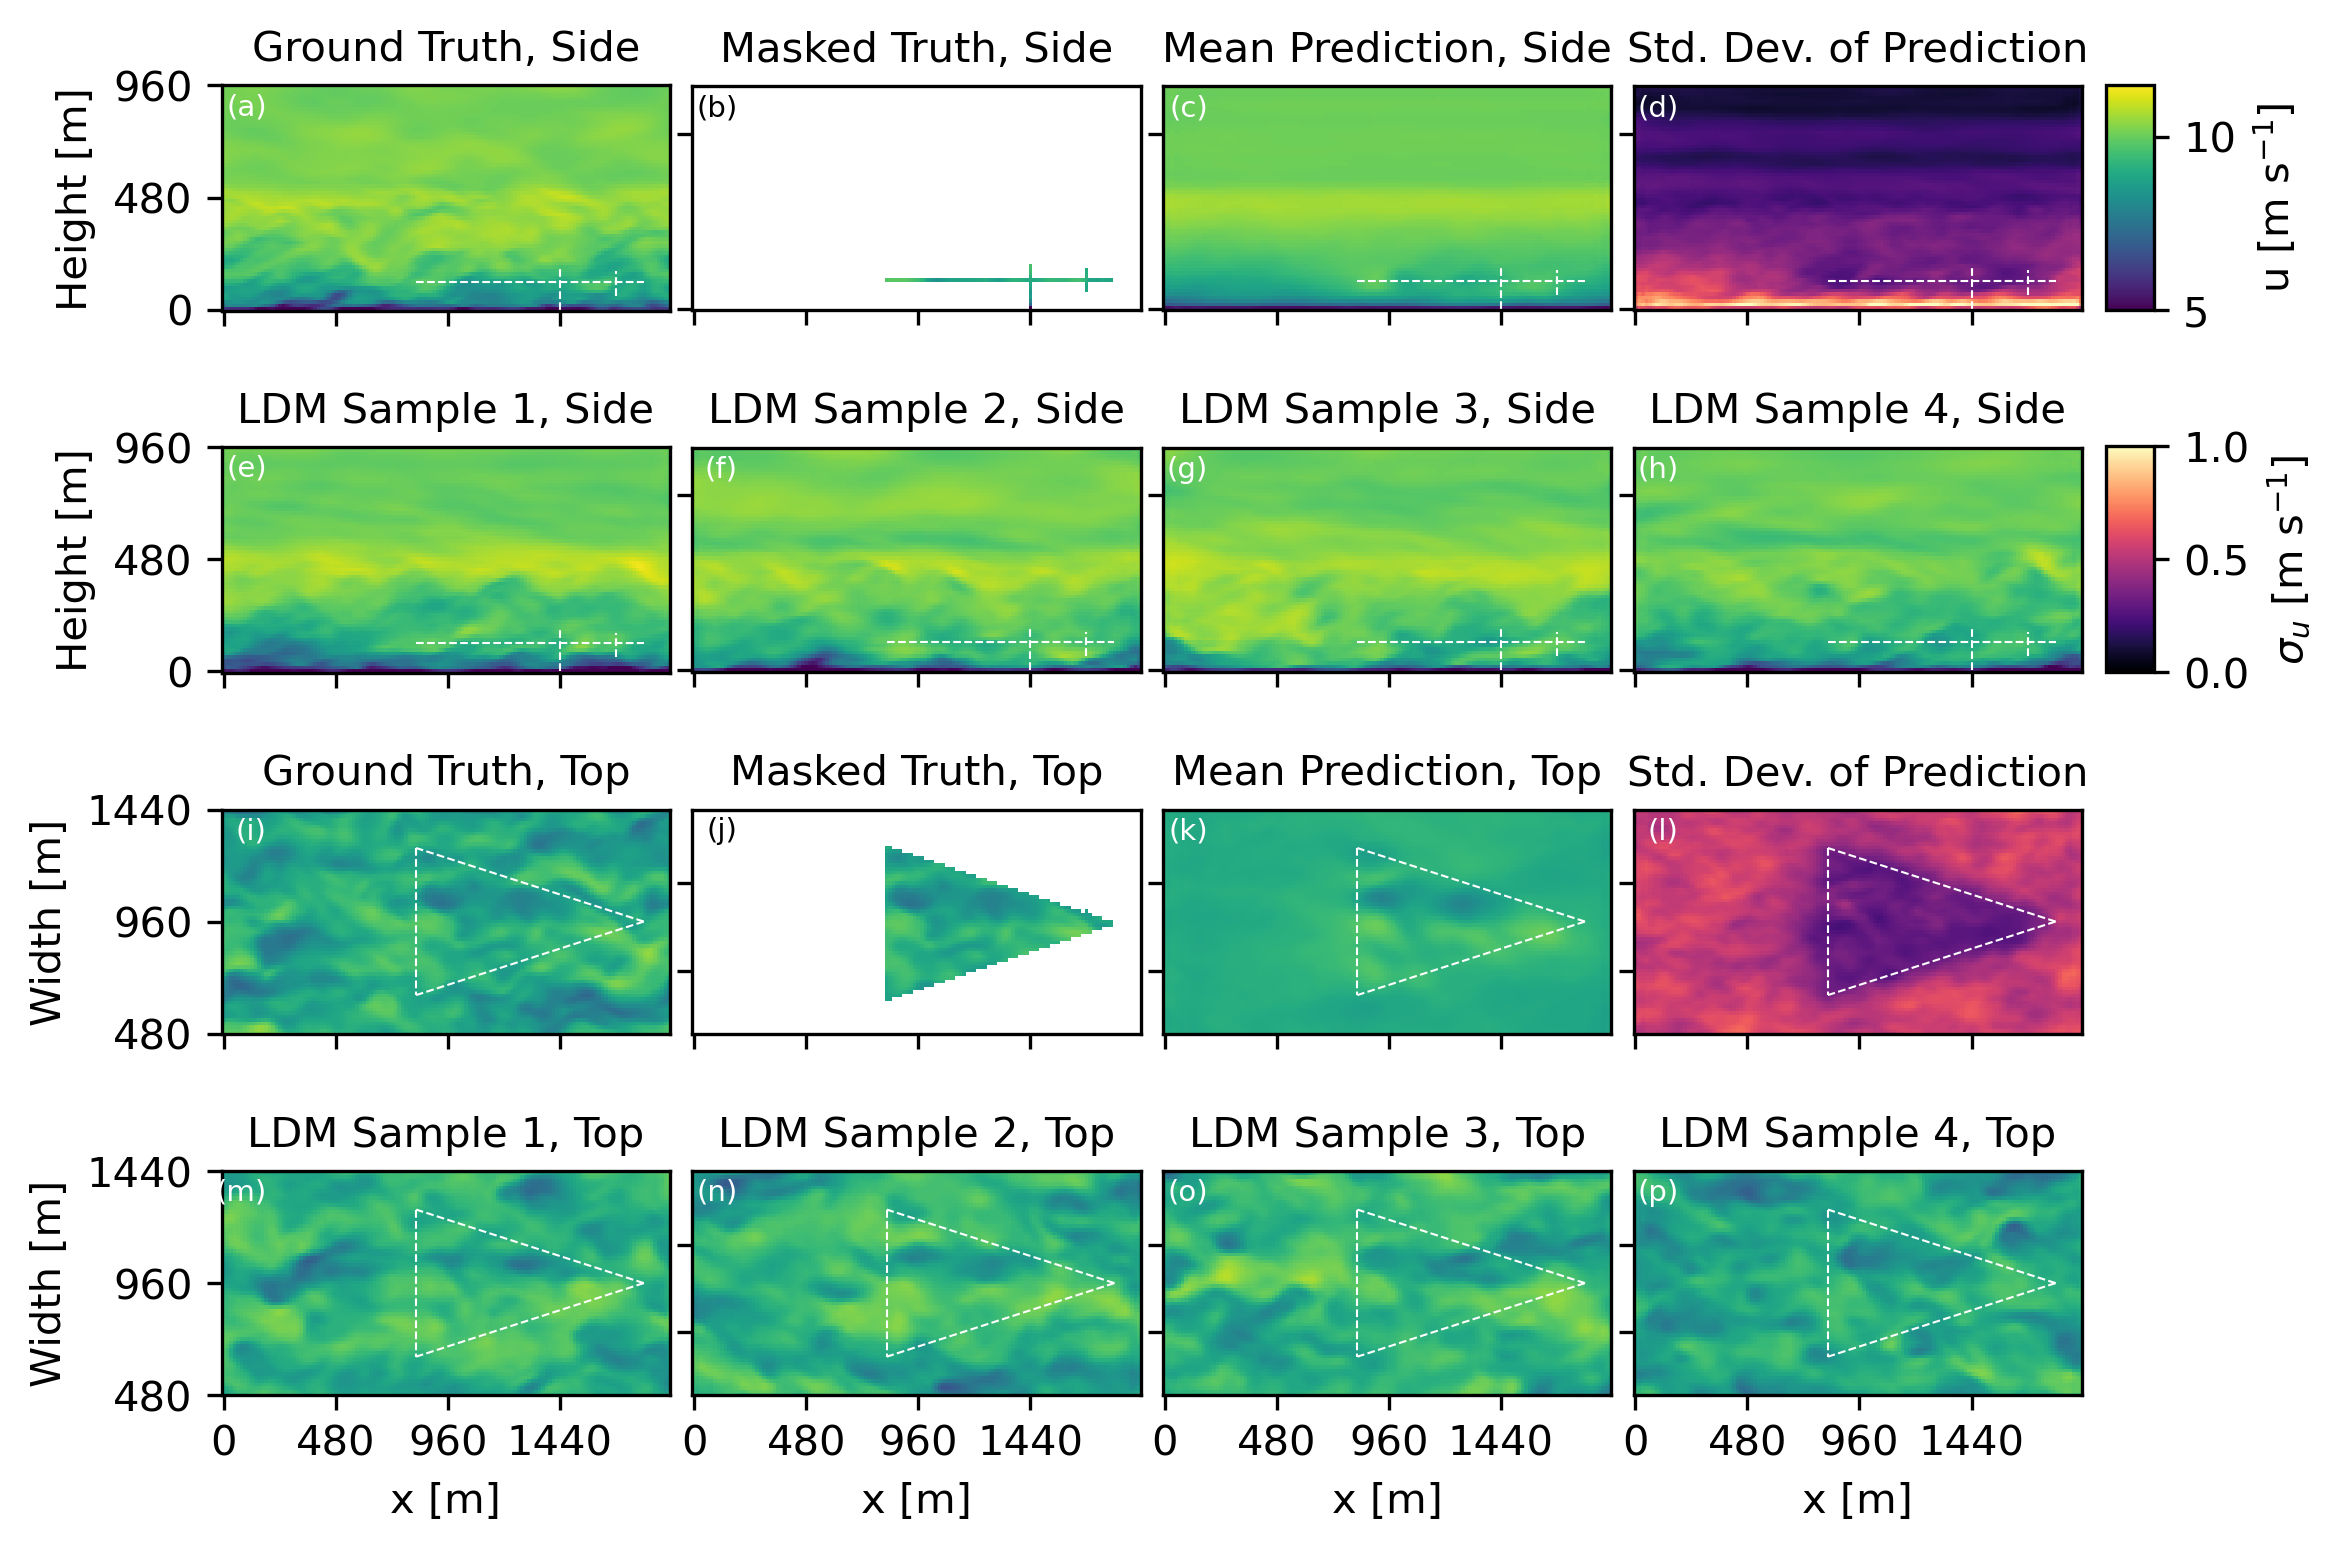

In [21]:
### Side view + Top-down view
fig, ax = plt.subplots(4, 4, figsize=(8, 6.0), dpi=300, sharex=True)

plt.subplots_adjust(wspace=0.05)

for axs in ax[2,:]:
    axs.set_ylim(32,96)

for axs in ax[-1,:]:
    axs.set_xlabel('x [m]')
    axs.set_ylim(32,96)
    
for axs in [ax[0,0], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3]]:
    axs.plot([55, 120], [8, 8], color='white', ls='--', lw=0.5)
    axs.plot([96, 96], [0, 12], color='white', ls='--', lw=0.5)
    axs.plot([112, 112], [4, 11], color='white', ls='--', lw=0.5)
    
for axs in [ax[2,0], ax[2,2], ax[2,3], ax[3,0], ax[3,1], ax[3,2], ax[3,3]]:
    jlidar_offset = round((120-55)*np.tan(np.deg2rad(18)))
    axs.plot([120, 55], [64, 64+jlidar_offset], color='white', ls='--', lw=0.5)
    axs.plot([120, 55], [64, 64-jlidar_offset], color='white', ls='--', lw=0.5)
    axs.plot([55, 55], [64+jlidar_offset, 64-jlidar_offset], color='white', ls='--', lw=0.5)

# velnum = 0
# varmin = 5
# varmax = 11.5
yind = 64
zind = 8

## Plot data
im1 = ax[0,0].imshow(ds3['u_gt'].isel(y=yind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[0,1].imshow(ds3['u_mask'].isel(y=yind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[0,2].imshow(ds3['u_sample'].isel(y=yind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[0,3].imshow(ds3['u_sample'].isel(y=yind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')

im1 = ax[2,0].imshow(ds3['u_gt'].isel(z=zind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[2,1].imshow(ds3['u_mask'].isel(z=zind).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im2 = ax[2,2].imshow(ds3['u_sample'].isel(z=zind).mean('sample').T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im3 = ax[2,3].imshow(ds3['u_sample'].isel(z=zind).std('sample').T,
            vmin=0.0,
            vmax=1.0,
            origin='lower',
            cmap='magma')


im1 = ax[1,0].imshow(ds3['u_sample'].isel(y=yind,sample=0).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,1].imshow(ds3['u_sample'].isel(y=yind,sample=1).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,2].imshow(ds3['u_sample'].isel(y=yind,sample=2).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[1,3].imshow(ds3['u_sample'].isel(y=yind,sample=3).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

im1 = ax[3,0].imshow(ds3['u_sample'].isel(z=zind,sample=0).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[3,1].imshow(ds3['u_sample'].isel(z=zind,sample=1).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[3,2].imshow(ds3['u_sample'].isel(z=zind,sample=2).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')
im1 = ax[3,3].imshow(ds3['u_sample'].isel(z=zind,sample=3).T,
            vmin=varmin,
            vmax=varmax,
            origin='lower')

## Titles and axes
ax[0,0].set_title("Ground Truth, Side", fontsize=10)
ax[0,1].set_title("Masked Truth, Side", fontsize=10)
ax[0,2].set_title("Mean Prediction, Side", fontsize=10)
ax[0,3].set_title("Std. Dev. of Prediction", fontsize=10)

ax[2,0].set_title("Ground Truth, Top", fontsize=10)
ax[2,1].set_title("Masked Truth, Top", fontsize=10)
ax[2,2].set_title("Mean Prediction, Top", fontsize=10)
ax[2,3].set_title("Std. Dev. of Prediction", fontsize=10)

ax[1,0].set_title("LDM Sample 1, Side", fontsize=10)
ax[1,1].set_title("LDM Sample 2, Side", fontsize=10)
ax[1,2].set_title("LDM Sample 3, Side", fontsize=10)
ax[1,3].set_title("LDM Sample 4, Side", fontsize=10)

ax[3,0].set_title("LDM Sample 1, Top", fontsize=10)
ax[3,1].set_title("LDM Sample 2, Top", fontsize=10)
ax[3,2].set_title("LDM Sample 3, Top", fontsize=10)
ax[3,3].set_title("LDM Sample 4, Top", fontsize=10)

ax[0,0].set_ylabel("Height [m]")
ax[2,0].set_ylabel("Width [m]")
ax[1,0].set_ylabel("Height [m]")
ax[3,0].set_ylabel("Width [m]")

## Axes
ax[0,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_yticks(np.array([0, 32, 64]))
ax[1,0].set_xticks(np.array([0, 32, 64, 96]))
ax[1,0].set_xticklabels(15*np.array([0, 32, 64, 96]))
ax[0,0].set_yticklabels(15*np.array([0, 32, 64]))
ax[1,0].set_yticklabels(15*np.array([0, 32, 64]))

ax[2,0].set_yticks(np.array([32, 64, 96]))
ax[2,0].set_yticklabels(15*np.array([32, 64, 96]))
ax[3,0].set_yticks(np.array([32, 64, 96]))
ax[3,0].set_yticklabels(15*np.array([32, 64, 96]))

for axs in ax[:,1:].flatten():
    axs.set_yticklabels([])

## Colorbars
cax1 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[0,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('u [m s$^{-1}$]', fontsize=10)
cbar1.ax.tick_params(labelsize=10) 

cax2 = fig.add_axes([ax[0,3].get_position().x1+0.01,
                     ax[1,-1].get_position().y0,
                     0.02,
                     ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label('$\sigma_u$ [m s$^{-1}$]', fontsize=10)
cbar2.ax.tick_params(labelsize=10) 

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.10,
          0.87,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
ax[0,1].text(0.10,
      0.87,
      f'(b)',
      fontsize=7,
      transform = ax[0,1].transAxes,
      horizontalalignment='right',
        color='black')
ax[2,1].text(0.10,
      0.87,
      f'(j)',
      fontsize=7,
      transform = ax[2,1].transAxes,
      horizontalalignment='right',
        color='black')

# plt.savefig('../figs/qual_cond_raaw_planes3_u_top_and_side.pdf', bbox_inches='tight')
    
plt.show()